In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor, Pool
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
#from  typing import
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
import scipy.stats as stats
#!pip install catboost optuna scikit-learn numpy

In [24]:
# Load dataset
df = pd.read_csv("data/cleaned_data_after_imputation.csv")

# Define numeric and categorical columns
numeric_columns = ["bedroomCount", "toilet_and_bath", "habitableSurface", "facedeCount", "hasTerrace", "totalParkingCount"]
categorical_columns = ["type", "subtype", "province", "locality", "postCode", "buildingCondition", "epcScore"]

for col in categorical_columns:
    df[col] = df[col].astype(str).fillna("nan")

# Separate features and target
X = df[numeric_columns + categorical_columns]
y = df["price"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=480,
    learning_rate=0.17,
    depth=6,
    loss_function='RMSE',
    verbose=0,                # Set to 100 to see logs every 100 iterations
    random_state=42
)

# Fit the model, specifying categorical features by name
catboost_model.fit(X_train, y_train, cat_features=categorical_columns)

# Make predictions
train_preds = catboost_model.predict(X_train)
test_preds = catboost_model.predict(X_test)

# Evaluation
print("CatBoost MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))

CatBoost MSE (test): 37943982656.32603
R² (train): 0.8747889766956223
R² (test): 0.792308413152205
MAE (train): 82062.76920364324
MAE (test): 92931.3937221141
MAPE (train): 0.19213794593724062
MAPE (test): 0.2032430420584097


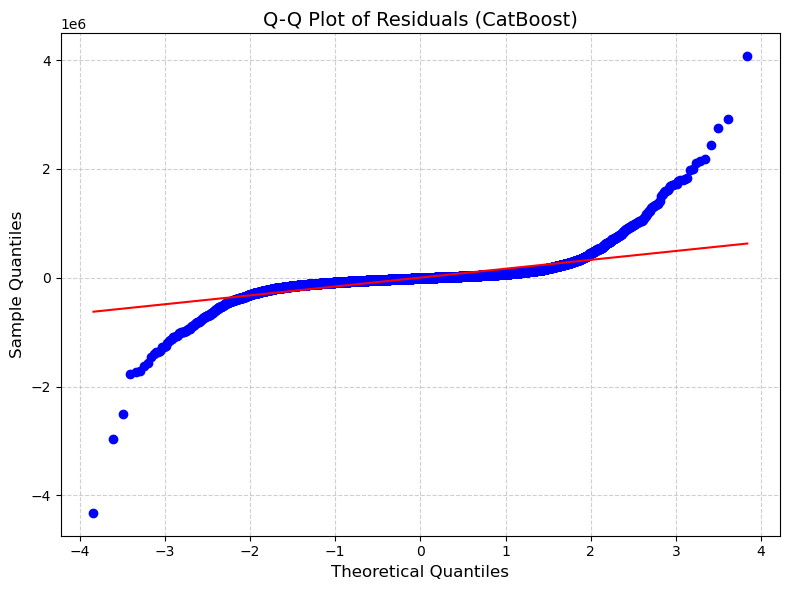

In [21]:
residuals = y_test - test_preds

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (CatBoost)", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [15]:
# Prepare CatBoost Pool objects
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
val_pool = Pool(X_test, y_test, cat_features=categorical_columns)

# Initialize CatBoost model
catboost_model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.17,
    depth=5,
    loss_function='RMSE',
    eval_metric='MAE',
    early_stopping_rounds=50,
    verbose=100,
    random_state=42
)

# Fit the model
catboost_model.fit(train_pool, eval_set=val_pool)

# Predictions
train_preds = catboost_model.predict(X_train)
test_preds = catboost_model.predict(X_test)

# Evaluation
print("\n📊 Evaluation Metrics:")
print("MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))

0:	learn: 234326.4050742	test: 234406.5794105	best: 234406.5794105 (0)	total: 50.5ms	remaining: 40.3s
100:	learn: 104325.5898686	test: 107536.8845630	best: 107536.8845630 (100)	total: 4.38s	remaining: 30.3s
200:	learn: 97707.8523906	test: 102914.4047802	best: 102914.4047802 (200)	total: 8.73s	remaining: 26s
300:	learn: 94235.5479572	test: 100996.2473654	best: 100983.7506709 (299)	total: 13.3s	remaining: 22.1s
400:	learn: 91736.0954035	test: 100028.0302692	best: 100028.0302692 (400)	total: 17.6s	remaining: 17.5s
500:	learn: 89691.8389587	test: 99060.7896982	best: 99060.7896982 (500)	total: 22.2s	remaining: 13.2s
600:	learn: 87869.2940588	test: 98242.7503451	best: 98224.5166889 (598)	total: 27.1s	remaining: 8.96s
700:	learn: 86463.9453063	test: 97907.4019393	best: 97907.4019393 (700)	total: 31.8s	remaining: 4.49s
799:	learn: 85053.3525581	test: 97401.9625324	best: 97393.3575264 (797)	total: 36.5s	remaining: 0us

bestTest = 97393.35753
bestIteration = 797

Shrink model to first 798 iterat

In [22]:
# --- Remove outliers from the 'price' column using IQR ---
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows within bounds
df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]
# Define numeric and categorical columns
numeric_columns = ["bedroomCount", "toilet_and_bath", "habitableSurface", "facedeCount", "hasTerrace", "totalParkingCount"]
categorical_columns = ["type", "subtype", "province", "locality", "postCode", "buildingCondition", "epcScore"]

for col in categorical_columns:
    df[col] = df[col].astype(str).fillna("nan")

# Separate features and target
X = df[numeric_columns + categorical_columns]
y = df["price"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=900,
    learning_rate=0.23,
    depth=7,
    loss_function='RMSE',
    verbose=0,                # Set to 100 to see logs every 100 iterations
    random_state=42
)

# Fit the model, specifying categorical features by name
catboost_model.fit(X_train, y_train, cat_features=categorical_columns)

# Make predictions
train_preds = catboost_model.predict(X_train)
test_preds = catboost_model.predict(X_test)

# Evaluation
print("CatBoost MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))


CatBoost MSE (test): 6487286158.160448
R² (train): 0.8445881118394487
R² (test): 0.7709086948719855
MAE (train): 47005.0783274936
MAE (test): 56723.0822078453
MAPE (train): 0.1515688050506186
MAPE (test): 0.18226728567152492


In [ ]:
residuals = y_test - test_preds

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (CatBoost)", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()